the source for Aice - link: https://www.gutenberg.org/ebooks/11

In [ ]:
import torch
import os
import torch.nn as nn #用于神经网络模块
import numpy as np
from torch.nn.utils import clip_grad_norm #用于梯度裁剪

In [ ]:
class Dictionary(object): #定义Dictionary类，用于词汇表的构建和管理。
    def __init__(self):
        self.word2idx = {} #存储词到索引的映射，idx用于记录当前词汇表的大小。
        self.idx2word = {} #存储索引到词的映射，idx用于记录当前词汇表的大小。
        self.idx = 0

    def add_word(self, word):#用于向词汇表中添加新词。如果词不在词汇表中，则将其添加并更新索引
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self): #__len__方法返回词汇表的大小，即词汇表中词的数量
        return len(self.word2idx)

In [ ]:
class TextProcess(object): #定义TextProcess类，用于文本处理

    def __init__(self):
        self.dictionary = Dictionary() #初始化时创建一个Dictionary实例

    def get_data(self, path, batch_size=20): #get_data方法用于从文件中读取数据并进行处理。首先打开文件并统计词的总数，同时将每个词添加到词汇表中
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
              # 将行拆分为单词，并在行末添加<eos>标记
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                   # 将每个单词添加到词汇表中
                    self.dictionary.add_word(word)
        #Create a 1-D tensor that contains the index of all the words in the file
        rep_tensor = torch.LongTensor(tokens) #创建一个长整型张量rep_tensor用于存储词的索引。
        index = 0
        with open(path, 'r') as f: #再次遍历文件，将每个词转换为索引并存储在张量中
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    rep_tensor[index] = self.dictionary.word2idx[word]
                    index += 1
        #Find out how many batches we need    计算需要的批次数量，去除多余的词，使张量的大小适应批次大小。最后将张量重塑为(batch_size, num_batches)的形状并返回
        num_batches = rep_tensor.shape[0] // batch_size
        #Remove the remainder (Filter out the ones that don't fit)
        rep_tensor = rep_tensor[:num_batches*batch_size]
        # return (batch_size,num_batches)
        rep_tensor = rep_tensor.view(batch_size, -1)
        return rep_tensor

In [ ]:
embed_size = 128    #Input features to the LSTM
hidden_size = 1024  #Number of LSTM units
num_layers = 1
num_epochs = 20
batch_size = 20
timesteps = 30
learning_rate = 0.002

In [ ]:
corpus = TextProcess()

In [ ]:
rep_tensor = corpus.get_data('alice.txt', batch_size)

In [ ]:
#rep_tensor is the tensor that contains the index of all the words. Each row contains 1659 words by default
print(rep_tensor.shape)

torch.Size([20, 1484])


In [ ]:
vocab_size = len(corpus.dictionary)
print(vocab_size)

5290


In [ ]:
num_batches = rep_tensor.shape[1] // timesteps
print(num_batches)

49


In [ ]:
class TextGenerator(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers): #__init__函数初始化模型的各个层，包括词嵌入层、LSTM层和线性层
        """
        初始化文本生成器模型

        参数:
        - vocab_size: 词汇表大小，即模型可以生成的不同词汇的数量
        - embed_size: 词嵌入的维度大小
        - hidden_size: LSTM隐藏层的维度大小
        - num_layers: LSTM的层数
        """
        super(TextGenerator, self).__init__()
        # 定义词嵌入层，将词汇表中的每个词映射到一个固定大小的向量
        self.embed = nn.Embedding(vocab_size, embed_size)
        # 定义LSTM层，处理嵌入后的词向量序列
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # 定义线性层，将LSTM的输出映射回词汇表大小的向量，用于预测下一个词
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h):
        """
        前向传播函数

        参数:
        - x: 输入的词索引序列，形状为 (batch_size, sequence_length)
        - h: LSTM的初始隐藏状态和细胞状态，形状为 (num_layers, batch_size, hidden_size)

        返回:
        - out: 预测的词汇表概率分布，形状为 (batch_size * sequence_length, vocab_size)
        - (h, c): LSTM的隐藏状态和细胞状态
        """
        # Perform Word Embedding # 将输入的词索引序列转换为词嵌入向量
        x = self.embed(x)
        #Reshape the input tensor
        #x = x.view(batch_size,timesteps,embed_size) # 通过LSTM层处理嵌入向量序列，得到输出和新的隐藏状态、细胞状态
        out, (h, c) = self.lstm(x, h)
        # Reshape the output from (samples,timesteps,output_features) to a shape appropriate for the FC layer
        # (batch_size*timesteps, hidden_size)
        # 将LSTM的输出形状从 (batch_size, sequence_length, hidden_size) 转换为 (batch_size * sequence_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        # Decode hidden states of all time steps
        # 通过线性层将LSTM的输出映射到词汇表大小的向量
        out = self.linear(out)
        return out, (h, c)

### 函数和参数分析

- **`__init__`函数**:
    - `vocab_size` (int): 词汇表大小，决定了模型可以生成的不同词汇的数量。
    - `embed_size` (int): 词嵌入的维度大小，决定了每个词嵌入向量的维度。
    - `hidden_size` (int): LSTM隐藏层的维度大小，决定了LSTM的输出维度。
    - `num_layers` (int): LSTM的层数，决定了LSTM的深度。

- **`forward`函数**:
    - `x` (Tensor): 输入的词索引序列，形状为 (batch_size, sequence_length)。
    - `h` (Tuple[Tensor, Tensor]): LSTM的初始隐藏状态和细胞状态，形状为 (num_layers, batch_size, hidden_size)。
    - 返回:
        - `out` (Tensor): 预测的词汇表概率分布，形状为 (batch_size * sequence_length, vocab_size)。
        - `(h, c)` (Tuple[Tensor, Tensor]): LSTM的隐藏状态和细胞状态。

### 优化建议

1. **批量处理优化**:
    - 当前代码中，LSTM的输出被重塑为 (batch_size * sequence_length, hidden_size)，这可能会影响后续处理的效率。可以考虑在LSTM层之后直接应用线性层，而不是重塑输出。

2. **增加Dropout层**:
    - 为了防止过拟合，可以在LSTM层和线性层之间添加Dropout层。

3. **参数初始化**:
    - 可以对模型的参数进行初始化，以提高模型的训练效果和稳定性。

4. **使用PackedSequence**:
    - 对于变长序列，可以使用`torch.nn.utils.rnn.pack_padded_sequence`和`torch.nn.utils.rnn.pad_packed_sequence`来提高LSTM的计算效率。

示例代码优化:
```python
class TextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.5):
        super(TextGenerator, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h):
        x = self.embed(x)
        out, (h, c) = self.lstm(x, h)
        out = self.dropout(out)
        out = self.linear(out.reshape(out.size(0) * out.size(1), out.size(2)))
        return out, (h, c)
```

通过上述优化，可以进一步提高模型的性能和训练效果。

In [ ]:
model = TextGenerator(vocab_size, embed_size, hidden_size, num_layers) # 初始化文本生成器模型
# 这里实例化了TextGenerator模型，传入了词汇表大小、词嵌入维度、LSTM隐藏层维度和LSTM层数。
# vocab_size (int): 词汇表大小。
# embed_size (int): 词嵌入的维度大小。
# hidden_size (int): LSTM隐藏层的维度大小。
# num_layers (int): LSTM的层数。

In [ ]:
loss_fn = nn.CrossEntropyLoss() # 定义损失函数为交叉熵损失，用于多分类问题
# 使用nn.CrossEntropyLoss作为损失函数，适用于多分类问题。
# 交叉熵损失函数会计算预测值和真实值之间的差异，并返回一个标量损失值。

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 定义优化器为Adam优化器，传入模型参数和学习率
# 使用Adam优化器来更新模型参数。
# model.parameters()返回模型的所有参数。
# lr=learning_rate设置学习率，控制参数更新的步长。

In [ ]:
def detach(states):
    """
If we have a tensor z,'z.detach()' returns a tensor that shares the same storage
as 'z', but with the computation history forgotten. It doesn't know anything
about how it was computed. In other words, we have broken the tensor z away from its past history
Here, we want to perform truncated Backpropagation
TBPTT splits the 1,000-long sequence into 50 sequences (say) each of length 20 and treats each sequence of length 20 as
a separate training case. This is a sensible approach that can work well in practice, but it is blind to temporal
dependencies that span more than 20 timesteps.
    """
    return [state.detach() for state in states]

In [ ]:
for epoch in range(num_epochs):
    # 外层循环遍历每个训练周期（epoch）。
    # 初始化LSTM的隐藏状态和细胞状态，形状为 (num_layers, batch_size, hidden_size)。
    # Set initial hidden and cell states
    states = (torch.zeros(num_layers, batch_size, hidden_size), #创建一个全零张量，用于初始化LSTM的隐藏状态和细胞状态
              torch.zeros(num_layers, batch_size, hidden_size))

    for i in range(0, rep_tensor.size(1) - timesteps, timesteps):
      # 内层循环遍历输入数据，按时间步（timesteps）分割成小批量。
      # inputs 是当前时间步的输入序列，targets 是对应的目标序列
        # Get mini-batch inputs and targets
        inputs = rep_tensor[:, i:i+timesteps] # --> (:, 0:0+30)   Output---> (:,1:31)
        targets = rep_tensor[:, (i+1):(i+1)+timesteps]
        #String: Black Horse is here
        #input: Black Horse     Output: lack Horse i

        outputs,_ = model(inputs, states) #通过模型前向传播获取输出和新的隐藏状态。
        loss = loss_fn(outputs, targets.reshape(-1)) #使用交叉熵损失函数计算损失，targets.reshape(-1) 将目标序列展平为一维

        #backpropogation and weight update
        model.zero_grad()
        loss.backward()
        #Perform Gradient Clipping. clip_value (float or int) is the maximum allowed value of the gradients
        #The gradients are clipped in the range [-clip_value, clip_value]. This is to prevent the exploding gradient problem
        clip_grad_norm(model.parameters(), 0.5) # 执行梯度裁剪，防止梯度爆炸 裁剪范围为 [-0.5, 0.5]。
        optimizer.step()

        # 计算当前步数
        step = (i+1) // timesteps
        # 每100步打印一次损失
        if step % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss.item()))


<ipython-input-15-69c25f07fb5f>:18: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  clip_grad_norm(model.parameters(), 0.5)


Epoch [1/20], Loss: 8.5744
Epoch [2/20], Loss: 5.9559
Epoch [3/20], Loss: 5.2065
Epoch [4/20], Loss: 4.7079
Epoch [5/20], Loss: 4.2431
Epoch [6/20], Loss: 3.6795
Epoch [7/20], Loss: 3.3270
Epoch [8/20], Loss: 2.9271
Epoch [9/20], Loss: 2.4488
Epoch [10/20], Loss: 2.0544
Epoch [11/20], Loss: 1.6888
Epoch [12/20], Loss: 1.4392
Epoch [13/20], Loss: 1.2134
Epoch [14/20], Loss: 0.9853
Epoch [15/20], Loss: 0.7115
Epoch [16/20], Loss: 0.4882
Epoch [17/20], Loss: 0.3013
Epoch [18/20], Loss: 0.2042
Epoch [19/20], Loss: 0.1248
Epoch [20/20], Loss: 0.0859


### 代码解释

```python
for i in range(0, rep_tensor.size(1) - timesteps, timesteps):
    inputs = rep_tensor[:, i:i+timesteps]
    targets = rep_tensor[:, (i+1):(i+1)+timesteps]
```

这段代码的目的是将输入序列 `rep_tensor` 按照时间步（`timesteps`）分割成多个小批量，以便进行批量训练。具体解释如下：

1. **`rep_tensor.size(1) - timesteps`**:
    - `rep_tensor.size(1)` 返回 `rep_tensor` 的第二个维度的大小，即序列的长度。
    - 减去 `timesteps` 是为了确保在最后一个时间步时不会超出序列的长度。

2. **`range(0, rep_tensor.size(1) - timesteps, timesteps)`**:
    - `range` 函数生成一个从 `0` 到 `rep_tensor.size(1) - timesteps` 的序列，步长为 `timesteps`。
    - 这样可以确保每次迭代时，`i` 的值都会增加 `timesteps`，从而分割出一个新的时间步。

3. **`inputs = rep_tensor[:, i:i+timesteps]`**:
    - `inputs` 是从 `rep_tensor` 中提取的一个小批量输入序列，形状为 `(batch_size, timesteps)`。
    - 例如，当 `i=0` 时，`inputs` 为 `rep_tensor[:, 0:0+timesteps]`，即从第 `0` 个时间步到第 `timesteps` 个时间步的子序列。

4. **`targets = rep_tensor[:, (i+1):(i+1)+timesteps]`**:
    - `targets` 是对应的目标序列，形状为 `(batch_size, timesteps)`。
    - 例如，当 `i=0` 时，`targets` 为 `rep_tensor[:, 1:1+timesteps]`，即从第 `1` 个时间步到第 `timesteps+1` 个时间步的子序列。
    - 这样可以确保 `targets` 是 `inputs` 的下一个时间步的序列，用于训练模型预测下一个词。

### 代码示例

假设 `rep_tensor` 的形状为 `(batch_size, sequence_length)`，`timesteps` 为 `30`，`batch_size` 为 `2`，`sequence_length` 为 `100`，则代码执行过程如下：

```python
rep_tensor = torch.arange(200).reshape(2, 100)  # 示例数据

timesteps = 30
for i in range(0, rep_tensor.size(1) - timesteps, timesteps):
    inputs = rep_tensor[:, i:i+timesteps]
    targets = rep_tensor[:, (i+1):(i+1)+timesteps]
    print(f"i: {i}")
    print(f"inputs: {inputs}")
    print(f"targets: {targets}")
```

输出结果：

```
i: 0
inputs: tensor([[  0,   1,   2, ...,  27,  28,  29],
                [100, 101, 102, ..., 127, 128, 129]])
targets: tensor([[  1,   2,   3, ...,  28,  29,  30],
                 [101, 102, 103, ..., 128, 129, 130]])

i: 30
inputs: tensor([[ 30,  31,  32, ...,  57,  58,  59],
                [130, 131, 132, ..., 157, 158, 159]])
targets: tensor([[ 31,  32,  33, ...,  58,  59,  60],
                 [131, 132, 133, ..., 158, 159, 160]])

i: 60
inputs: tensor([[ 60,  61,  62, ...,  87,  88,  89],
                [160, 161, 162, ..., 187, 188, 189]])
targets: tensor([[ 61,  62,  63, ...,  88,  89,  90],
                 [161, 162, 163, ..., 188, 189, 190]])
```

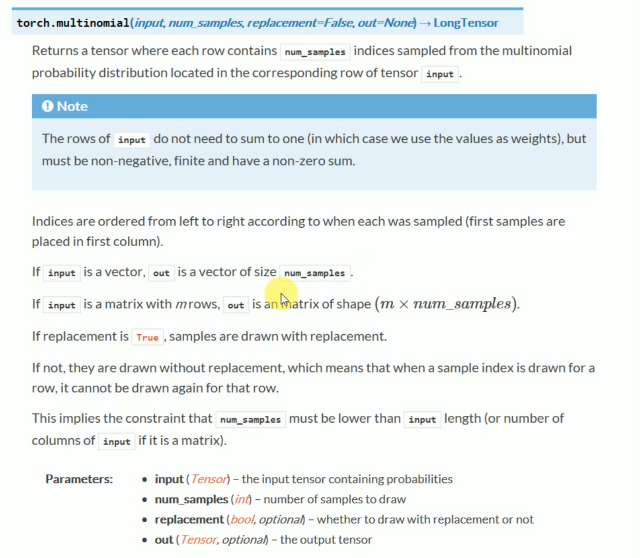

In [ ]:
# 测试模型
# 使用torch.no_grad()上下文管理器来禁用梯度计算
# 这在测试或推理阶段是必要的，以减少内存消耗并加快计算速度
with torch.no_grad():
    # 打开一个名为'results.txt'的文件，以写入模式
    # 这将用于保存生成的文本结果
    with open('results.txt', 'w') as f:
        # 初始化隐藏状态和细胞状态
        # 使用torch.zeros创建全零张量，形状为(num_layers, 1, hidden_size)
        # num_layers: LSTM的层数
        # hidden_size: 每层的隐藏状态维度
        state = (torch.zeros(num_layers, 1, hidden_size),
                 torch.zeros(num_layers, 1, hidden_size))

        # 随机选择一个单词ID，并将其转换为形状(1, 1)
        # torch.randint生成一个在[0, vocab_size)范围内的随机整数
        # .long()将其转换为长整型
        # .unsqueeze(1)增加一个维度，使其形状变为(1, 1)
        input = torch.randint(0, vocab_size, (1,)).long().unsqueeze(1)

        # 生成500个单词
        for i in range(500):
            # 将输入和状态传递给模型，获取输出和新的状态
            output, _ = model(input, state)
            print(output.shape)  # 打印输出的形状以进行调试

            # 从输出的指数中采样一个单词ID
            # .exp()计算输出的指数
            prob = output.exp()
            # torch.multinomial从概率分布中采样一个单词ID
            # num_samples=1表示采样一个样本
            word_id = torch.multinomial(prob, num_samples=1).item()
            print(word_id)  # 打印采样的单词ID以进行调试

            # 用采样的单词ID替换输入，以便下一个时间步使用
            input.fill_(word_id)

            # 将结果写入文件
            # 从词典中获取单词
            word = corpus.dictionary.idx2word[word_id]
            # 如果单词是'<eos>'，则写入换行符，否则写入单词加空格
            word = '\n' if word == '<eos>' else word + ' '
            f.write(word)

            # 每生成100个单词，打印一次进度
            if (i + 1) % 100 == 0:
                print('Sampled [{}/{}] words and save to {}'.format(i + 1, 500, 'results.txt'))


In [ ]:
# Test the model
with torch.no_grad(): #使用 torch.no_grad() 禁用梯度计算，以提高推理速度并减少内存消耗
    with open('results.txt', 'w') as f:
        # Set intial hidden ane cell states
        state = (torch.zeros(num_layers, 1, hidden_size), #初始化 LSTM 的隐藏状态和细胞状态，形状为 (num_layers, 1, hidden_size)
                 torch.zeros(num_layers, 1, hidden_size))
        # Select one word id randomly and convert it to shape (1,1) 随机选择一个词 ID，并将其转换为形状 (1, 1)，作为模型的初始输入
        input = torch.randint(0,vocab_size, (1,)).long().unsqueeze(1)

        for i in range(500):
          # 循环生成 500 个词。
          # 通过模型前向传播获取输出和新的隐藏状态。
          # 计算输出的指数以获取概率分布。
          # 从概率分布中采样一个词 ID。
          # 将采样的词 ID 作为下一个时间步的输入。
          output, _ = model(input, state)
          print(output.shape)
          # Sample a word id from the exponential of the output
          prob = output.exp()
          word_id = torch.multinomial(prob, num_samples=1).item() #从给定的概率分布中采样一个词 ID
          print(word_id)
          # Replace the input with sampled word id for the next time step
          input.fill_(word_id)

          # Write the results to file
          word = corpus.dictionary.idx2word[word_id]
          word = '\n' if word == '<eos>' else word + ' '
          f.write(word)
          # 将词 ID 转换为对应的词。
          # 如果词是 <eos>（句子结束符），则写入换行符，否则写入词和空格。
          # 每生成 100 个词打印一次进度。

          if (i+1) % 100 == 0:
              print('Sampled [{}/{}] words and save to {}'.format(i+1, 500, 'results.txt'))

torch.Size([1, 5290])
3
torch.Size([1, 5290])
2344
torch.Size([1, 5290])
38
torch.Size([1, 5290])
3
torch.Size([1, 5290])
4188
torch.Size([1, 5290])
861
torch.Size([1, 5290])
2882
torch.Size([1, 5290])
96
torch.Size([1, 5290])
1274
torch.Size([1, 5290])
167
torch.Size([1, 5290])
9
torch.Size([1, 5290])
236
torch.Size([1, 5290])
265
torch.Size([1, 5290])
1909
torch.Size([1, 5290])
265
torch.Size([1, 5290])
1909
torch.Size([1, 5290])
150
torch.Size([1, 5290])
114
torch.Size([1, 5290])
5
torch.Size([1, 5290])
1767
torch.Size([1, 5290])
34
torch.Size([1, 5290])
7
torch.Size([1, 5290])
300
torch.Size([1, 5290])
1598
torch.Size([1, 5290])
20
torch.Size([1, 5290])
35
torch.Size([1, 5290])
2678
torch.Size([1, 5290])
44
torch.Size([1, 5290])
2986
torch.Size([1, 5290])
5
torch.Size([1, 5290])
603
torch.Size([1, 5290])
20
torch.Size([1, 5290])
35
torch.Size([1, 5290])
2678
torch.Size([1, 5290])
5
torch.Size([1, 5290])
366
torch.Size([1, 5290])
5
torch.Size([1, 5290])
5
torch.Size([1, 5290])
1981


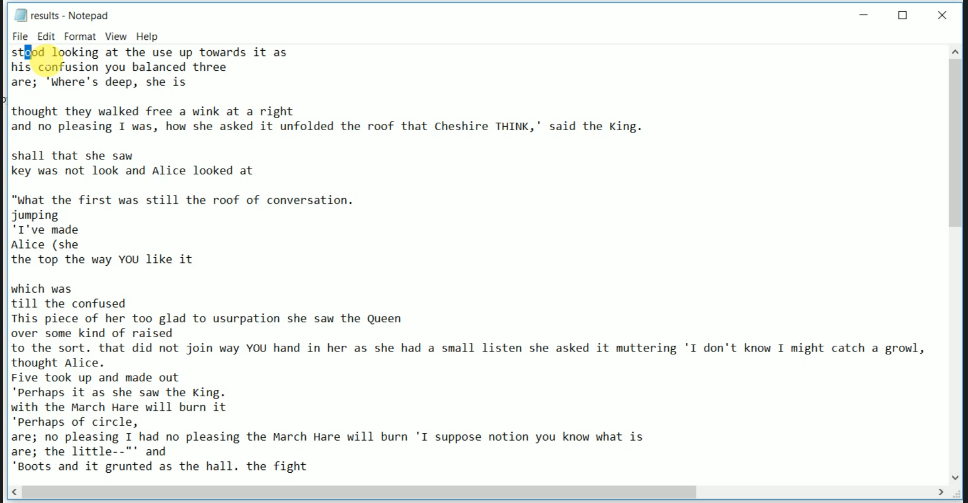

您可以这样做并应用它并获得更好的结果:
1. 您可以做的一件事就是增加时期的数量。我们仅对它进行了 20 个时期的训练。20 个 epoch非常低。你可以训练它大概 200，也许 500 个 epoch 就能得到更好的结果，毫无疑问，20 个 epoch 非常低，但这里我们只想快速完成训练,所以我们只能向您展示结果。

2. 您可以做的另一件事是增加层数。所以一层也是有的，也是非常非常小的。因此您可能想使用两层。您可以尝试两层或三层。您可以在此处的参数中执行两件事。

3. 您还可以做的一件事是使用 dropouts。所以在这里，好的，在你的文本生成中，你可以使用 dropout 层，当然，这将帮助你减少过度拟合。

4. 您可以做的另一件事是学习成绩衰减，正如我们在迁移学习教程中所做的那样，你可以降低学习率,每隔，比如说，10 个时期。因此，每隔几个时期，你就会降低学习率。


### 总结

这段文字主要讨论了如何在PyTorch中改进一个基础模型。作者强调了这是一个基础概念展示，并提供了一些改进模型的方法，包括增加训练周期、增加层数、使用dropout层和学习率衰减等。此外，还讨论了截断的反向传播技术及其在长时间步序列中的应用。

### 重要信息提取

1. **基础模型展示**：当前模型只是为了展示概念，没有进行优化。
2. **改进方法**：
   - 增加训练周期（例如从20增加到200或500）。
   - 增加层数（例如从一层增加到两层或三层）。
   - 使用dropout层来减少过拟合。
   - 使用学习率衰减，每隔几个周期减少学习率。
3. **截断的反向传播**：
   - 将长序列分割成较短的序列进行训练。
   - 适用于长时间步序列。

### 专有名词解释

1. **PyTorch**：一个开源的深度学习框架，广泛用于研究和生产环境。
2. **Epoch（训练周期）**：在机器学习中，一个epoch表示整个训练数据集被完整地通过一次。
3. **Dropout**：一种防止神经网络过拟合的技术，通过在训练过程中随机忽略一些神经元。
4. **学习率衰减**：一种优化技术，通过逐渐减少学习率来提高模型的训练效果。
5. **截断的反向传播（Truncated Backpropagation Through Time）**：一种处理长序列数据的技术，通过将长序列分割成较短的序列来进行训练。